In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import GlobalMaxPooling1D, Dense

In [2]:
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/LaBSE/2", trainable=False)

In [28]:

def normalize(embeds):
    l2_norm = np.linalg.norm(embeds, 2, axis=1, keepdims=True)
    return embeds / l2_norm

def build_model(max_seq_len):
#     src_input = Input((max_seq_len), name="src_input")
#     tgt_input = Input((max_seq_len), name="tgt_input")
    
    src_word_ids = Input((max_seq_len), dtype=tf.int32)
    src_mask_ids = Input((max_seq_len), dtype=tf.int32)
    src_type_ids = Input((max_seq_len), dtype=tf.int32)
    
    tgt_word_ids = Input((max_seq_len), dtype=tf.int32)
    tgt_mask_ids = Input((max_seq_len), dtype=tf.int32)
    tgt_type_ids = Input((max_seq_len), dtype=tf.int32)
    
    src_x = {"input_word_ids": src_word_ids,
             "input_mask": src_mask_ids,
             "input_type_ids": src_type_ids}
    
    tgt_x = {"input_word_ids": tgt_word_ids,
             "input_mask": tgt_mask_ids,
             "input_type_ids": tgt_type_ids}
#     src_x = preprocessor(src_input)
#     tgt_x = preprocessor(tgt_input)
    
    src_x = encoder(src_x)["default"]
    tgt_x = encoder(tgt_x)["default"]
    
#     src_x = normalize(src_x)
#     tgt_x = normalize(tgt_x)
    src_x = tf.math.l2_normalize(src_x, axis=1, epsilon=1e-12, name=None)
    tgt_x = tf.math.l2_normalize(tgt_x, axis=1, epsilon=1e-12, name=None)
    
    # np.matmul(english_embeds, np.transpose(italian_embeds))
    x = tf.concat([src_x, tgt_x], axis=1)
#     x = GlobalMaxPooling1D(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model([src_word_ids, src_mask_ids, src_type_ids, 
                     tgt_word_ids, tgt_mask_ids, tgt_type_ids], output)
    
    return model

In [40]:
embeds = tf.constant([[1,2,3,4], [1,2, 3, 4]], dtype=tf.float32)
embeds / np.linalg.norm(embeds, 2, axis=1, keepdims=True)

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[0.18257418, 0.36514837, 0.5477225 , 0.73029673],
       [0.18257418, 0.36514837, 0.5477225 , 0.73029673]], dtype=float32)>

In [45]:
# embeds
tf.math.l2_normalize(
    embeds, axis=1, epsilon=1e-12, name=None
)

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[0.18257418, 0.36514837, 0.5477226 , 0.73029673],
       [0.18257418, 0.36514837, 0.5477226 , 0.73029673]], dtype=float32)>

In [49]:
# 1 / np.sqrt(30)
# tf.keras.layers.Lambda(
#       lambda x: tf.nn.l2_normalize(x, axis=1))(embeds)
# tf.nn.l2_normalize(embeds, axis=1)

In [29]:
max_seq_len = 128
model = build_model(max_seq_len)

In [30]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 128)]        0                                            
____________________________________________________________________________________________

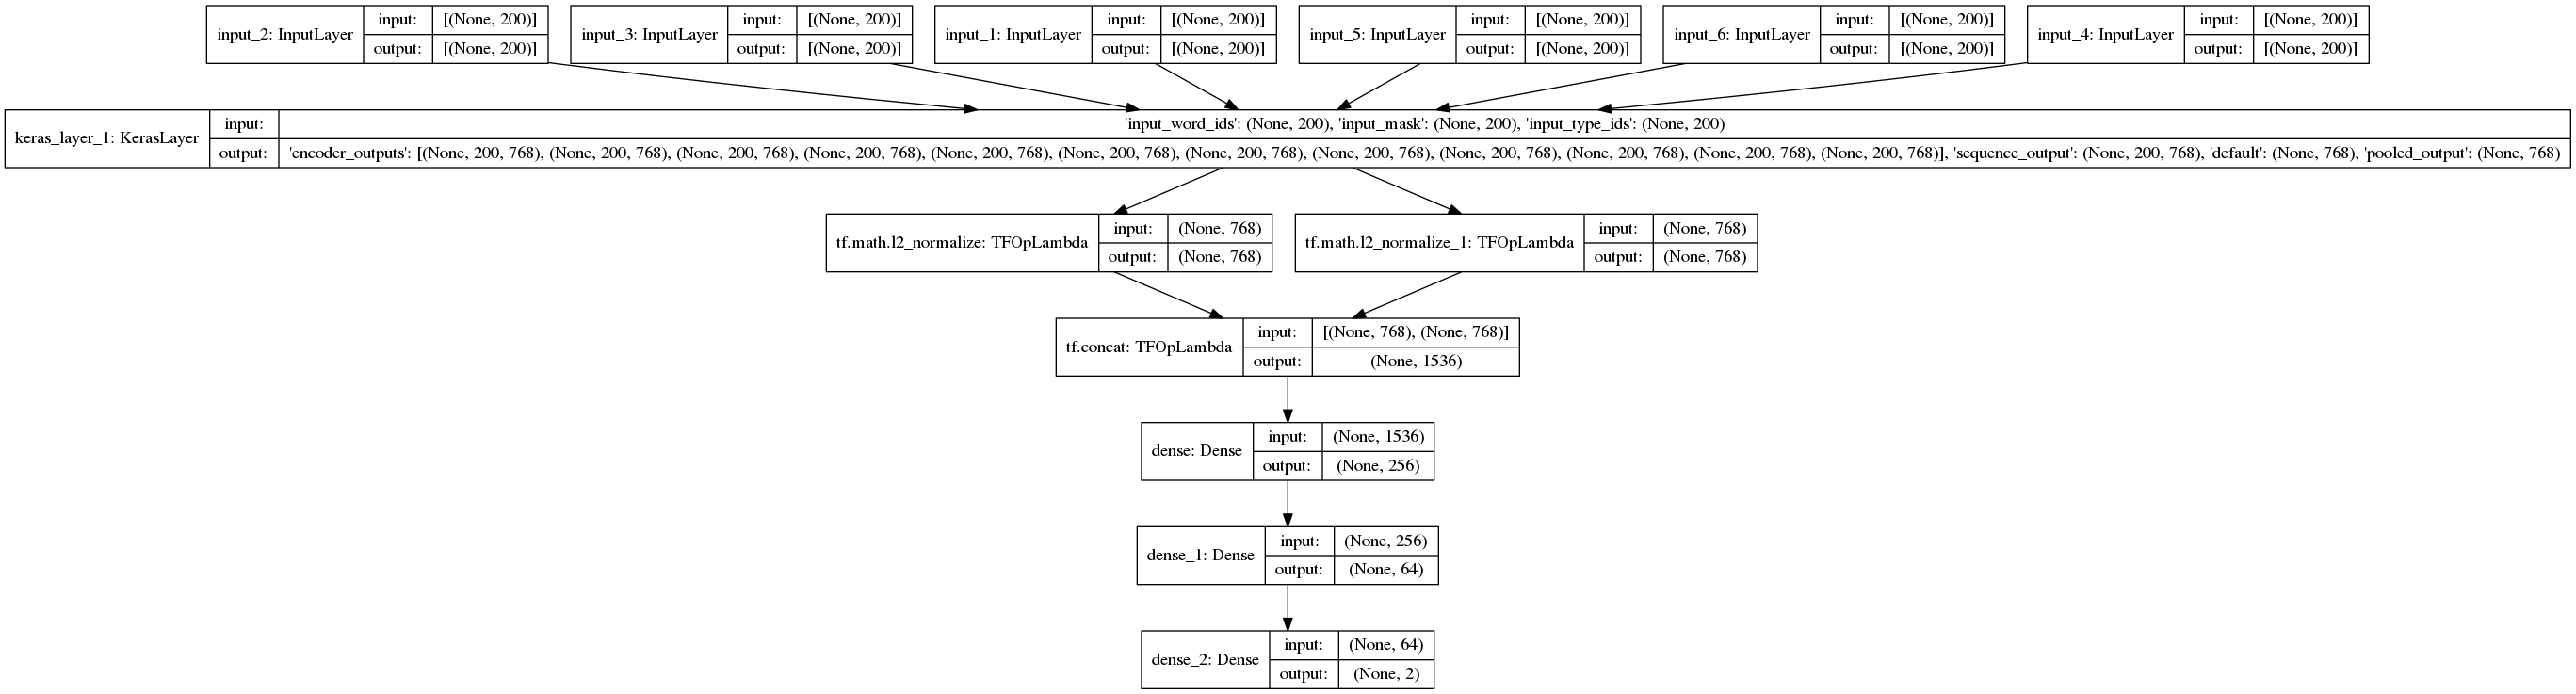

In [5]:
tf.keras.utils.plot_model(model, "LaBSE_based.png", show_shapes=True)

In [8]:
from preprocessing import TextPreprocess

srcLang = "eng"
tgtLang = "fra"
src_vocab_size = 20000
src_len = 150
tgt_vocab_size = 20000
tgt_len = 150
train_data_dir = "/home/ethan/Yappn_Gitlab/TQC/tqa/train"
label_class_map = {"good": 1, "bad": 0}
tp = TextPreprocess(srcLang, tgtLang, src_vocab_size=src_vocab_size, src_len=src_len,
                    tgt_vocab_size=tgt_vocab_size, tgt_len=tgt_len)
src_integers, tgt_integers, labels = tp.read_dataset_from_directory(train_data_dir, label_class_map)


Importing Data
	1 pairs of good English-French files found.
	1 pairs of bad English-French files found.
Importing Data Complete.
	335073 good entries
	128875 bad entries


In [14]:
src_integers = preprocessor(src_integers)
tgt_integers = preprocessor(tgt_integers)

In [26]:
labels = np.array(labels)

In [ ]:
epochs = 2
batch_size = 128
num_samples = len(labels)
steps_per_epoch = int(num_samples / batch_size)
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x=[src_integers["input_word_ids"], src_integers["input_mask"], src_integers["input_type_ids"],
             tgt_integers["input_word_ids"], tgt_integers["input_mask"], tgt_integers["input_type_ids"]],
          y=labels,
          batch_size=batch_size,
          epochs=epochs,
          steps_per_epoch=steps_per_epoch,
          validation_split=0.2)

Epoch 1/2
3624/3624 [==============================] - ETA: 0s - loss: 0.0664 - accuracy: 0.9782 

In [ ]:
src_integers.keys()
print(src_integers["input_word_ids"].shape)
print(src_integers["input_mask"])
print(src_integers["input_type_ids"].shape)